## Setup

In [0]:
!mkdir utils

In [0]:
from utils.file_utils import *
from utils.image_utils import *
from utils.generator_utils import *
from utils.tqdm_utils import *
from utils.keras_utils import *

Using TensorFlow backend.


In [0]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import os
import collections
import google.colab as colab
import pickle

import warnings
warnings.filterwarnings('ignore')

### Mount Google Drive

In [0]:
def mount_google_drive():
	'''
	# Functionality
		Mount google drive. Since colab does not save files, we want to make it easier to directly access files in google drive.
	# Arguments
		Nothing
	# Returns
		drive_root: the working directory mounted
	'''
	mount_directory = "/content/gdrive"
	drive = colab.drive
	drive.mount(mount_directory, force_remount=True)
	drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0]
	return drive_root



ROOT_DIR =  mount_google_drive()
CHECKPOINT_ROOT = ROOT_DIR+ "/captioning/checkpoints/"
DATASET_DIR = ROOT_DIR + "/Dataset/"

if not os.path.exists(DATASET_DIR):
  os.makedirs(DATASET_DIR)

if not os.path.exists(CHECKPOINT_ROOT):
  os.makedirs(CHECKPOINT_ROOT)

def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))
      
# example of checkpoint dir
print(get_checkpoint_path(4))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/captioning/checkpoints/weights_4


## Load embeddings

In [0]:
def save_pickle(obj, fn):
	'''
	# Functionality
		Save the data into pickle format
	# Arguments
		obj: the data object
		fn: the pickle file name
	# Returns
		Nothing. Just save to the file.
	'''
	with open(fn, "wb") as f:
		pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)


def read_pickle(fn):

	'''
	# Functionality
		Save the data into pickle format
	# Arguments
		fn: the pickle file name
	# Returns
		obj: the desired data object
	'''
	with open(fn, "rb") as f:
		return pickle.load(f)

In [0]:
# load prepared embeddings
train_img_embeds = read_pickle(DATASET_DIR + "train_img_embeds.pickle")
train_img_fns = read_pickle(DATASET_DIR + "train_img_fns.pickle")
val_img_embeds = read_pickle(DATASET_DIR + "val_img_embeds.pickle")
val_img_fns = read_pickle(DATASET_DIR + "val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(8278, 2048) 8278
(4050, 2048) 4050


In [0]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(DATASET_DIR)))

['train2014_sample.zip', 'val2014_sample.zip']

## Extract Labels (Captions)

In [0]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, DATASET_DIR + "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, DATASET_DIR + "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))
print(val_img_fns)

In [0]:
# preview captions data
train_captions[:2]

[['A white plate with a brownie and white frosting.',
  'A piece of chocolate cake on top of a white plate.',
  'a chocolate cake and a fork ready to be eat',
  'A chocolate desert on a plate with a fork. ',
  'A piece of chocolate dessert on a plate with a napkin and a fork.'],
 ['a man with a beard and a brown and white dog on a leash',
  'A man and his dog on a hike - both wearing backpacks',
  'A man and a dog standing on a dirt path in the woods.',
  'a man carrying a back pack walking a dog carrying a back pack',
  'A man with a backpack holding a dog on a leash.']]

## Let's go to NLP Part now!

### General Pipeline for captions of each image:
- Original Captions is a list of sentences of various lengths
-  Change every word to lower case
- Tokenize the senteces and build vocabulary (with specific threashold word frequencies). 
- Map each token to a number.
- Sentences then become list of list of numbers
- Pad and truncate the sequence of numbers to max len

In [0]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

  
  
def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    ### YOUR CODE HERE ###
    vocab_with_repeat = []
    for captions in train_captions:
      for sentence in captions:
        tokens = split_sentence(sentence)
        vocab_with_repeat += tokens
    counter = collections.Counter(vocab_with_repeat)
    
    vocab = []
    for element in counter:
      if counter[element] >= 5:
        vocab.append(element)
    vocab = list(set(vocab))
    vocab += [PAD, UNK, START, END]
    
    return {token: index for index, token in enumerate(sorted(vocab))}
    
    
    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    ### YOUR CODE HERE ###
    res = []
    for instance in captions:
      instance_list = []
      
      for sentence in instance:
        sentence_list = []
        sentence_list.append(vocab[START])
        
        # append tokens
        tokens = split_sentence(sentence)
        for token in tokens:
          if token not in vocab.keys():
            sentence_list.append(vocab[UNK])
          else:
            sentence_list.append(vocab[token])
        
        sentence_list.append(vocab[END])
        
        instance_list.append(sentence_list)
      res.append(instance_list)

    return res

In [0]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

3066


In [0]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [0]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    ###YOUR CODE HERE###
    matrix = []
    
    if max_len:
      max_len = min(max_len, len(max(batch_captions, key=len)))  
    else:
      max_len = len(max(batch_captions, key=len))
    
    for caption in batch_captions:
      if len(caption) < max_len:
        output = caption + [pad_idx] * (max_len-len(caption))
      elif len(caption) > max_len:
        output = caption[:max_len]
      else:
        output = caption
      matrix.append(output)

    return np.array(matrix)

In [0]:
# make sure you use correct argument in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

## Define architecture

In [0]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
IMG_SIZE = 299
pad_idx = vocab[PAD]

batch_size = 64
n_epochs = 15
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [0]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

W0712 18:36:10.622394 140361279477632 deprecation_wrapper.py:119] From /content/utils/keras_utils.py:68: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0712 18:36:10.625291 140361279477632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0712 18:36:10.626709 140361279477632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0712 18:36:10.646982 140361279477632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 18:36:10.647850 140361279477

In [0]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    ### YOUR CODE HERE ###
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last (last for not be input) for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    ### YOUR CODE HERE ###
    word_embeds = word_embed(sentences[:, :-1])
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    ### YOUR CODE HERE ###
    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])

    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    ### YOUR CODE HERE ###
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    
    # then, we flatten the ground truth (output side, compare with word_embeds) token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    ### YOUR CODE HERE ###
    flat_ground_truth = tf.reshape(sentences[:, 1:], [-1])

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    ### YOUR CODE HERE ###
    flat_loss_mask = tf.cast(tf.not_equal(flat_ground_truth, pad_idx), 'float32')

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    ### YOUR CODE HERE ###
    loss = tf.reduce_sum(xent*flat_loss_mask) / tf.reduce_sum(flat_loss_mask)

W0712 18:36:11.989533 140361279477632 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0712 18:36:11.994508 140361279477632 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0712 18:36:11.997472 140361279477632 deprecation.py:323] From <ipython-input-17-430d427f1f8e>:19: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a futu

In [0]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

## Training

In [0]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [0]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    ### YOUR CODE HERE ###
    indices = np.random.randint(0, len(images_embeddings), batch_size)
    batch_image_embeddings = images_embeddings[indices]
    
    ### YOUR CODE HERE ###
    batch_captions = []
    for i in indices:
      all_current_captions = indexed_captions[i]
      cap_idx = np.random.randint(0, len(all_current_captions))
      batch_captions.append(all_current_captions[cap_idx])
    batch_captions_matrix = batch_captions_to_matrix(batch_captions, pad_idx, max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [0]:
# you can load trained weights here
# uncomment the next line if you need to load weights
# saver.restore(s, get_checkpoint_path(epoch=4))

Look at the training and validation loss, they should be decreasing!

In [0]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")

**************************************************
Training loss: 3.950947
Epoch: 0, train loss: 3.9509467825889586, val loss: 3.3504215598106386
**************************************************
Training loss: 2.996984
Epoch: 1, train loss: 2.996983834505081, val loss: 2.982754559516907
**************************************************
Training loss: 2.680705
Epoch: 2, train loss: 2.6807051994800566, val loss: 2.874350709915161
**************************************************
Training loss: 2.494104
Epoch: 3, train loss: 2.4941035180091857, val loss: 2.827591459751129
**************************************************
Training loss: 2.362529
Epoch: 4, train loss: 2.362529140710831, val loss: 2.8155920243263246
**************************************************
Training loss: 2.246948


W0712 18:37:55.982235 140361279477632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Epoch: 5, train loss: 2.2469480113983153, val loss: 2.861932108402252
**************************************************
Training loss: 2.152399
Epoch: 6, train loss: 2.1523994661569597, val loss: 2.8659900879859923
**************************************************
Training loss: 2.061127
Epoch: 7, train loss: 2.061126788020134, val loss: 2.8858258152008056
**************************************************
Training loss: 1.990575
Epoch: 8, train loss: 1.990575444459915, val loss: 2.9221073722839357
**************************************************
Training loss: 1.908313
Epoch: 9, train loss: 1.9083133890628814, val loss: 2.997011590003967
**************************************************
Training loss: 1.838523
Epoch: 10, train loss: 1.838523150086403, val loss: 3.0681496167182924
**************************************************
Training loss: 1.768701
Epoch: 11, train loss: 1.7687007256746292, val loss: 3.0859017968177795
**************************************************
Train

In [0]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 1.5324882
Accuracy: 0.6193633952254642
Example 0
Predicted: a table table coffee with a and and a on it #END# on and and and and and and
Truth: a round glass table has coffee juice and rolls on it #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a street signs on attached in front of a building #END# #END# #END# #END# #END# and and and and
Truth: three street signs are seen in front of a building #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a man on a snow with skis on posing his #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a man in the snow on skis and with poles #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#



In [0]:
# save last graph weights to file!
saver.save(s, get_checkpoint_path())

'/content/gdrive/My Drive/captioning/checkpoints/weights'

# Inference
Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [0]:
class final_model:
    # CNN encoder
    K.set_learning_phase(False)
    encoder = keras.applications.InceptionV3(include_top=False)
    encoder = keras.models.Model(encoder.inputs, keras.layers.GlobalAveragePooling2D()(encoder.output))
    
    saver.restore(s, get_checkpoint_path())  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

87916544/87910968 [==============================] - 29s 0us/step


W0712 18:41:37.945595 140361279477632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [0]:
# This preprocessing function should be in the notebook not in the utils
# Since we may want to try different config every time. Should be custimizable. 
def preprocess(input, input_shape=(299, 299)):
    if type(input) is bytes:
      img = decode_image_from_raw_bytes(input)
    else:
      img = input
    img = image_center_crop(img)  # take center crop
    img = cv2.resize(img, input_shape)  # resize for our model
    img = img.astype("float32")  # prepare for normalization
    img = keras.applications.inception_v3.preprocess_input(img)  # preprocess for model
    return img

In [0]:
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

In [0]:
def inference(input):
    img = preprocess(input)
    
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

--2019-07-12 18:41:39--  https://cdn.pixabay.com/photo/2017/09/17/16/35/boats-2758962__340.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.82.97, 104.18.141.87, 2606:4700::6812:8d57, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.82.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34676 (34K) [image/jpeg]
Saving to: ‘boats-2758962__340.jpg’

boats-2758962__340. 100%[===================>]  33.86K  --.-KB/s    in 0.01s   

2019-07-12 18:41:39 (2.78 MB/s) - ‘boats-2758962__340.jpg’ saved [34676/34676]



W0712 18:41:40.578860 140361279477632 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


a group of sail boats floating on top of a beach


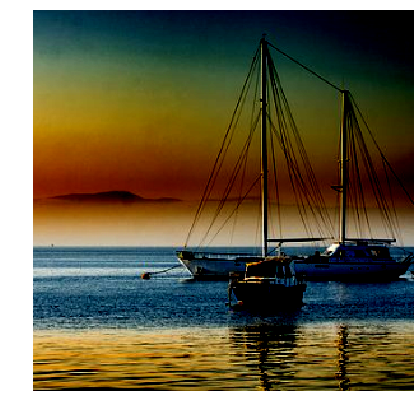

In [0]:
! wget https://cdn.pixabay.com/photo/2017/09/17/16/35/boats-2758962__340.jpg
inference(open("boats-2758962__340.jpg", "rb").read())